In [1]:
import sys
import os

# Add the path to the volatility_analysis directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, 'code', 'volatility_analysis'))
from volatility_pipeline import *

import torch
torch.set_grad_enabled(True)

In [ ]:
# Configuration parameters
FETCH_DATA = False  # Set to True to fetch new news data
FROM = "2023-01-01"
TO = "2025-05-31"
CUT = "2024-10-01"  # Date to split train/test data
MARKET_NAME = "DAX 40"
WINDOW = 7
EPOCHS = 200

In [3]:
# Define relevant keywords for DAX 40 news
keywords = [
    "dax",  # German stock index (equivalent to IBEX 35)
    "inflation",  # Inflation
    "zinssatz",  # Interest rates
    "zölle",  # Tariffs
    "wirtschaftswachstum",  # Economic growth
    "rezession",  # Recession
    "arbeitslosigkeit",  # Unemployment
    "subventionen",  # Subsidies
    "investition",  # Investment
    "expansion"  # Expansion
]

KEYWORDS = " OR ".join([f'"{keyword}"' for keyword in keywords])

In [4]:
import pandas as pd, time, random
from pygooglenews import GoogleNews
# Fetch news data function
def fetch_dax_news_data():
    gn = GoogleNews(lang="de", country="DE")

    all_frames = []

    start_dt = pd.to_datetime(FROM)
    end_dt   = pd.to_datetime(TO)

    while start_dt <= end_dt:
        stop_dt = min(start_dt + pd.Timedelta(days=WINDOW-1), end_dt)

        feed    = gn.search(KEYWORDS,
                            from_=start_dt.strftime("%Y-%m-%d"),
                            to_  =stop_dt.strftime("%Y-%m-%d"))

        df      = pd.DataFrame(
                    {"date":  [pd.to_datetime(e.published).tz_localize(None)
                                for e in feed["entries"]],
                    "title": [e.title for e in feed["entries"]]}
                )
        all_frames.append(df)

        # polite pause to avoid 429 errors
        time.sleep(random.uniform(1.0, 2.5))
        start_dt = stop_dt + pd.Timedelta(days=1)

    news_df = (pd.concat(all_frames, ignore_index=True)
                .drop_duplicates())          # remove overlaps
    
    # Remove the "- name of the news source" suffix from titles
    news_df['title'] = news_df['title'].str.replace(r' - .+$', '', regex=True)
    

    # Save to CSV
    os.makedirs("../news", exist_ok=True)
    news_df.to_csv(f"../news/news_data_{FROM}_{TO}_DAX.csv", index=False)
    
    return news_df

In [5]:
# Fetch or load news data
if FETCH_DATA:
    news_df = fetch_dax_news_data()
    print(f"Fetched {len(news_df)} news articles")
else:
    # Read the CSV file
    news_df = pd.read_csv(f"../news/news_data_{FROM}_{TO}_DAX.csv", parse_dates=['date'])
    print(f"Loaded {len(news_df)} news articles")

Fetched 11708 news articles


In [6]:
import yfinance

# Fetch DAX 40 market data using yfinance
dax40 = yfinance.Ticker("^GDAXI")
dax40_data = dax40.history(start=FROM, end=TO, interval="1d", auto_adjust=True)
dax40_data = dax40_data.reset_index()  # Convert index to column
dax40_data["Returns"] = dax40_data["Close"].pct_change()
dax40_data["Volatility"] = dax40_data["Returns"].rolling(window=21).std() * np.sqrt(252)
dax40_data = dax40_data.dropna().reset_index(drop=True)

# Remove hours from the date
dax40_data["Date"] = dax40_data["Date"].dt.date
# Remove hours from the date in news_df
news_df["date"] = news_df["date"].dt.date

print(f"Loaded {len(dax40_data)} days of DAX 40 market data")
dax40_data.head()

Loaded 592 days of DAX 40 market data


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,Volatility
0,2023-01-31,15081.169922,15136.219727,14993.589844,15128.269531,57047200,0.0,0.0,0.000145,0.123464
1,2023-02-01,15125.120117,15222.339844,15107.830078,15180.740234,57095200,0.0,0.0,0.003468,0.122377
2,2023-02-02,15275.000000,15520.969727,15264.309570,15509.190430,122979300,0.0,0.0,0.021636,0.122071
3,2023-02-03,15408.400391,15476.669922,15347.860352,15476.429688,76253700,0.0,0.0,-0.002112,0.121006
4,2023-02-06,15367.040039,15406.929688,15275.570312,15345.910156,54430400,0.0,0.0,-0.008433,0.123242


Splitting data at 2024-10-01...
Sentiment model loaded on device: cuda
GPU: NVIDIA GeForce RTX 4070
Calculating enhanced sentiment scores...
Computing sentiment predictions from scratch...
Processing 11708 news titles in batches of 32
Computed and cached sentiment predictions for 865 dates
Plotting sentiment distribution...


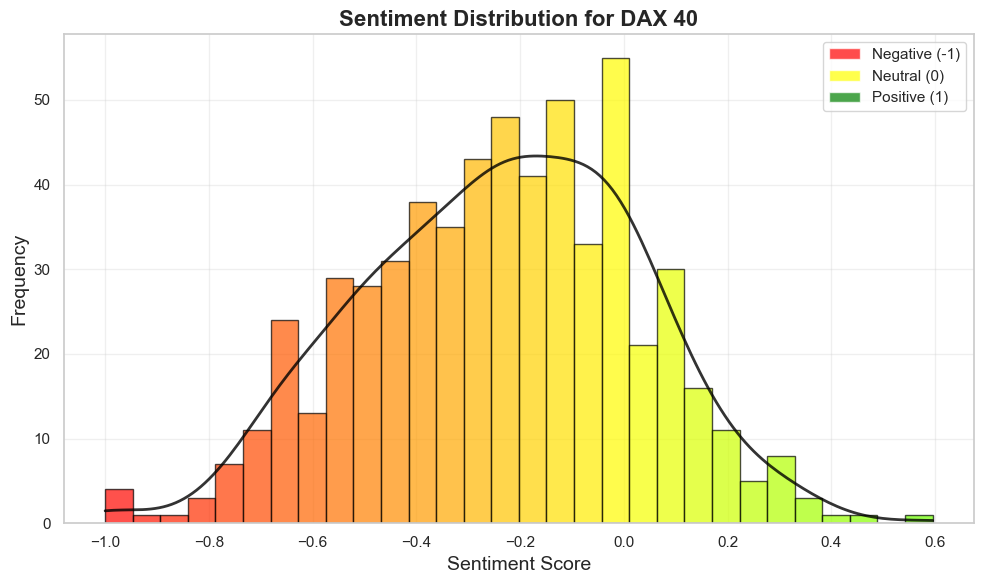

Final feature columns for model: ['Volatility_Smooth', 'news_sentiment_interaction', 'sentiment_std_5d', 'sentiment_std_7d', 'sentiment_per_news', 'sentiment_vol_interaction']


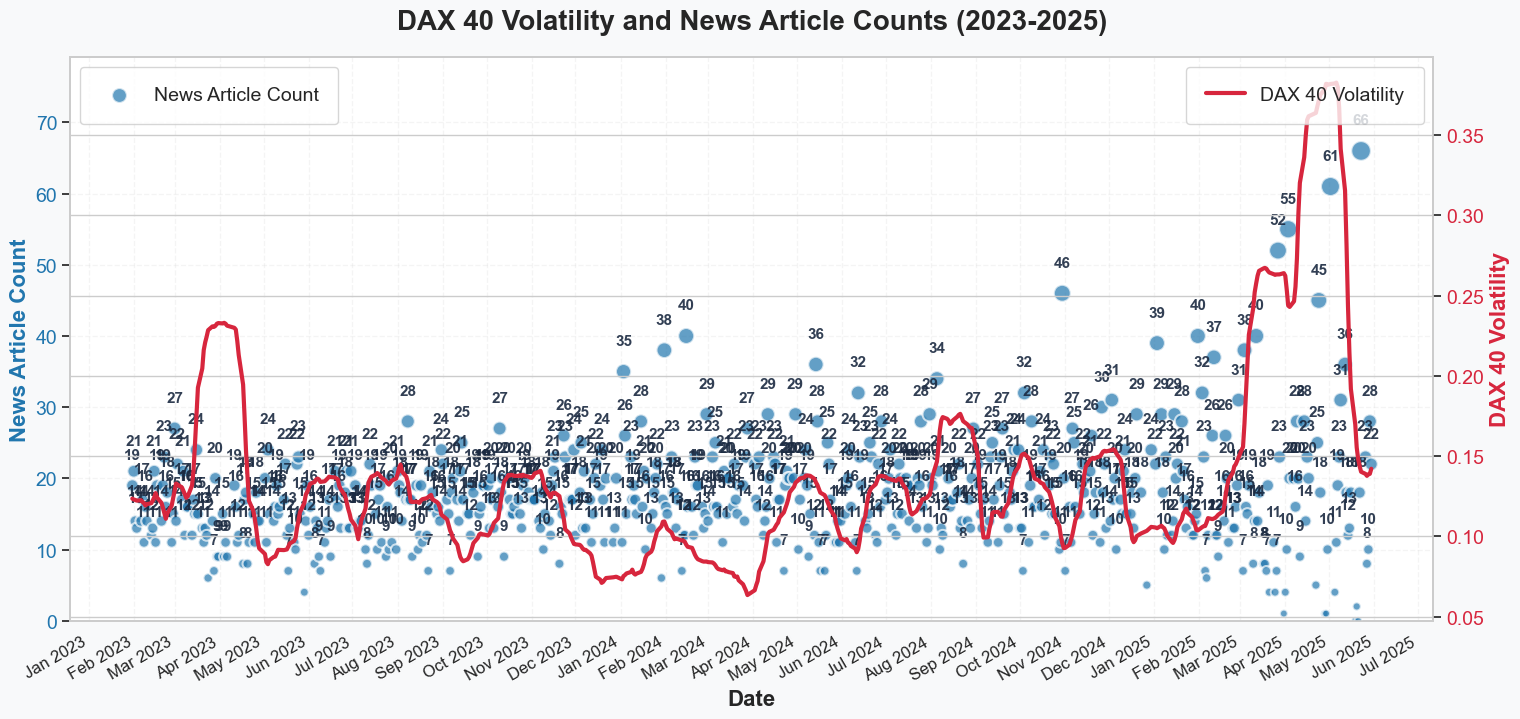

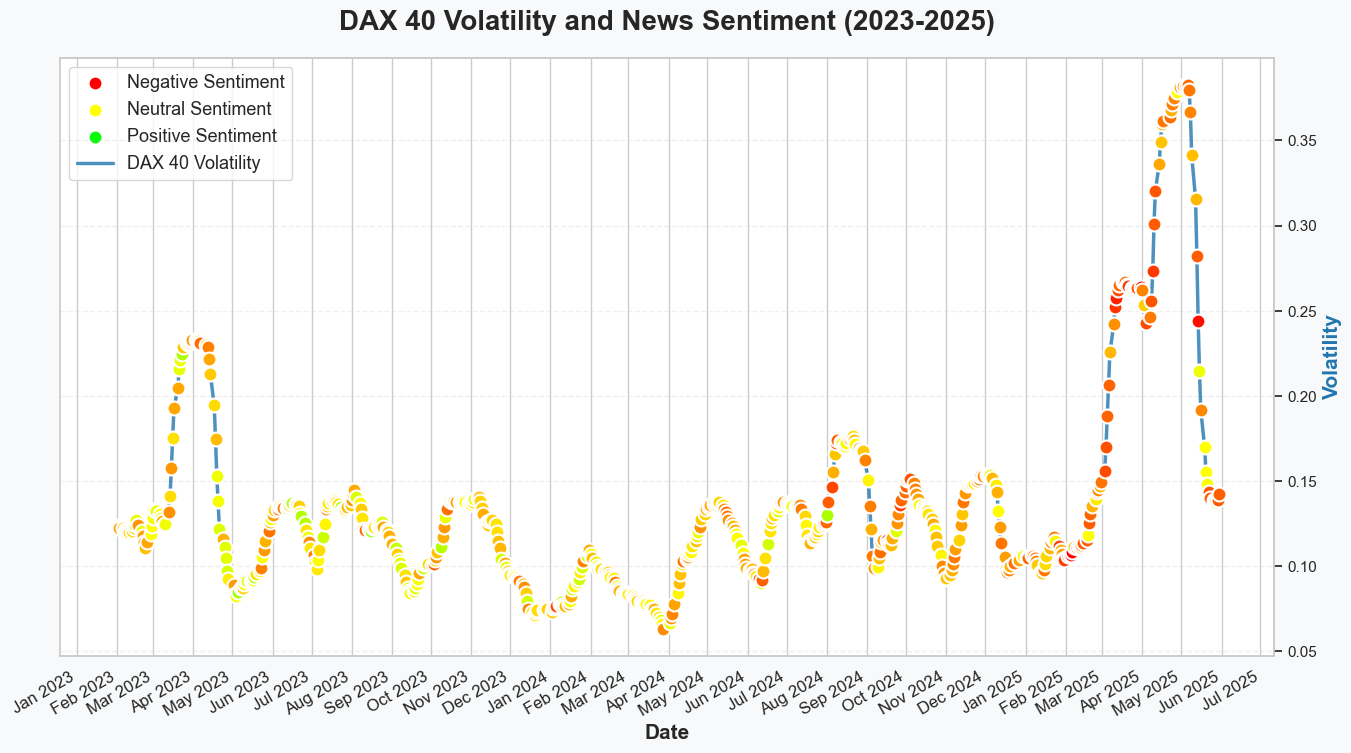

Preparing data for LSTM model...
Training enhanced LSTM model with early stopping...
Model initialized with 5314 trainable parameters
Epoch 1/200, Train Loss: 0.21330, Val Loss: 0.10708
Epoch 10/200, Train Loss: 0.00683, Val Loss: 0.00494
Epoch 20/200, Train Loss: 0.00479, Val Loss: 0.00376
Epoch 30/200, Train Loss: 0.00362, Val Loss: 0.00297
Epoch 40/200, Train Loss: 0.00266, Val Loss: 0.00232
Epoch 50/200, Train Loss: 0.00175, Val Loss: 0.00189
Epoch 60/200, Train Loss: 0.00130, Val Loss: 0.00185
Epoch 70/200, Train Loss: 0.00114, Val Loss: 0.00175
Epoch 80/200, Train Loss: 0.00104, Val Loss: 0.00166
Epoch 90/200, Train Loss: 0.00096, Val Loss: 0.00160
Epoch 100/200, Train Loss: 0.00090, Val Loss: 0.00154
Epoch 110/200, Train Loss: 0.00085, Val Loss: 0.00148
Epoch 120/200, Train Loss: 0.00080, Val Loss: 0.00143
Epoch 130/200, Train Loss: 0.00076, Val Loss: 0.00138
Epoch 140/200, Train Loss: 0.00072, Val Loss: 0.00133
Epoch 150/200, Train Loss: 0.00069, Val Loss: 0.00129
Epoch 160/200

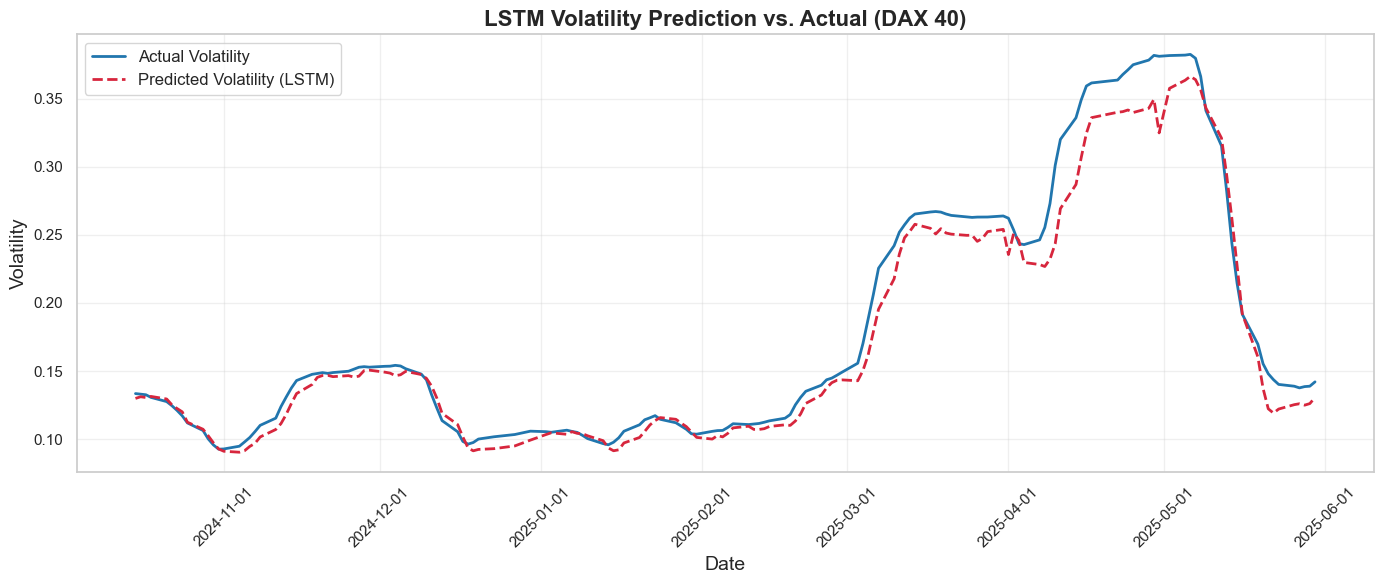

In [7]:
# Run the volatility analysis pipeline
results = run_volatility_pipeline(
    news_df=news_df,
    stock_data=dax40_data,
    market_name=MARKET_NAME,
    cut_date=CUT,
    epochs=EPOCHS,
)